In [1]:
from fine_tuning_tabpfn.finetune_tabpfn import fine_tune_tabpfn
from tabpfn.model.gatedtransformerv2 import GatedPerFeatureTransformer
# from tabpfn.model.gatedtransformer import GatedPerFeatureTransformer

In [1]:
from fine_tuning_tabpfn.finetune_tabpfn import fine_tune_tabpfn
from sklearn.datasets import load_iris, load_wine, fetch_openml,load_digits, load_breast_cancer
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from tabpfn.classifier import TabPFNClassifier
from tabpfn.regressor import TabPFNRegressor
import torch.nn as nn
import torch
from sklearn.metrics import accuracy_score,precision_score,recall_score
import numpy as np
import pandas as pd
import openml
import random
import datetime

## Dataset Loading

In [3]:
## Load OpenML dataset baseline score

In [4]:
def get_random_difficult_dataset():
    baseline_datasets = pd.read_csv('./openml_baseline_tabpfn.csv')
    interesting_eval_datasets = baseline_datasets[(baseline_datasets['accuracy'] <=0.8) &(baseline_datasets['# Features'] >=50) & (baseline_datasets['# NaNs'] ==0)].sort_values(by=['accuracy'],ascending=True)
    interesting_eval_datasets.id.to_list()
    dataset_id=random.sample(interesting_eval_datasets.id.to_list(),1)[0]
    dataset = openml.datasets.get_dataset(dataset_id)
    print("Dataset info",str(interesting_eval_datasets[interesting_eval_datasets['id']==dataset_id].to_dict("records")))
    X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute)
    return pd.DataFrame(X),pd.DataFrame(y), dataset_id

In [5]:
def load_synthetic_lspin_easy():
    np.random.seed(42)
    Xs1 = np.random.normal(loc=1,scale=0.5,size=(300,5))
    Ys1 = -2*Xs1[:,0]+1*Xs1[:,1]-0.5*Xs1[:,2]
    
    Xs2 = np.random.normal(loc=-1,scale=0.5,size=(300,5))
    Ys2 = -0.5*Xs2[:,2]+1*Xs2[:,3]-2*Xs2[:,4]
    X_data = np.concatenate((Xs1,Xs2),axis=0)
    Y_data = np.concatenate((Ys1.reshape(-1,1),Ys2.reshape(-1,1)),axis=0)
    Y_data = Y_data-Y_data.min()
    Y_data=Y_data/Y_data.max()
    y_labels = np.concatenate((np.array([0]*300),np.array([1]*300)))
    X_data = pd.DataFrame(X_data)
    y_labels = pd.DataFrame(y_labels)
    return X_data, y_labels

def load_synthetic_data_lspin_xor():
    N_train = 1500
    N_valid=300
    N_test = 300
    D=7
    np.random.seed(42)
    group_size=int(N_train/3)
    X_train = np.sign(np.random.normal(0,1,(N_train,D)))
    X_train = np.concatenate((X_train,
                             np.concatenate(([-1]*group_size,[0]*group_size,[1]*group_size)).reshape(-1,1)),axis=1)
    Y_train = np.concatenate((X_train[:group_size,0]*X_train[:group_size,1]+2*X_train[:group_size,-1],
                              X_train[group_size:(group_size*2),1]*X_train[group_size:(group_size*2),2]+2*X_train[group_size:(group_size*2),-1],
                              X_train[(group_size*2):(group_size*3),2]*X_train[(group_size*2):(group_size*3),3]+2*X_train[(group_size*2):(group_size*3),-1],
                             ),axis=0)
    Y_train = pd.DataFrame(Y_train)
    Y_train[0] = Y_train[0].apply(lambda x: 0 if x == 1 else x)
    Y_train[0] = Y_train[0].apply(lambda x: 1 if x == -1 else x)
    Y_train[0] = Y_train[0].apply(lambda x: 2 if x == 3 else x)
    Y_train[0] = Y_train[0].apply(lambda x: 3 if x == -3 else x)
    return pd.DataFrame(X_train), Y_train

## Evaluating Models

### Evaluating Custom Model

In [6]:
# Load data
# X, y = load_wine(return_X_y=True, as_frame=True)
# X, y = load_breast_cancer(return_X_y=True, as_frame=True)
# X,y,did = get_random_difficult_dataset()
# Load MNIST from OpenML; as_frame=True returns a Pandas DataFrame.
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
X, y = mnist["data"], mnist["target"]
y = y.astype(int)
X= pd.DataFrame(X)
y = pd.DataFrame(y)
did=1234
# digits = load_digits()
# X, y = pd.DataFrame(digits.data), pd.Series(digits.target)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.90,
    random_state=42,
    shuffle=True
)

In [7]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:


random_dataset_id = did
date_markup = '_'.join(str(datetime.datetime.now()).split()[0].split("-"))
# Finetune
save_path_to_fine_tuned_model = f"./fine_tuned_model_new_{date_markup}_gated_{random_dataset_id}.ckpt"
fine_tune_tabpfn(
    path_to_base_model="auto",
    save_path_to_fine_tuned_model=save_path_to_fine_tuned_model,
    # Finetuning HPs
    time_limit=200,
    finetuning_config={"learning_rate": 0.00001, "batch_size": 8,"min_patience": 300,"max_patience": 1000},
    validation_metric="log_loss",
    # Input Data
    X_train=X_train,
    y_train=y_train,
    categorical_features_index=None,
    device="cuda",  # use "cpu" if you don't have a GPU
    task_type="multiclass",
    gated=True,
    extra_configuration={'num_features_input':784},
    # Optional
    show_training_curve=True,  # Shows a final report after finetuning.
    logger_level=-100,  # Shows all logs, higher values shows less
    use_wandb=False,  # Init wandb yourself, and set to True
)




Loading GatedModelV2
Loaded Gated Model


Fine-tuning Steps:   0%|                                                                     | 1/10000 [00:00<?, ?it/s]

In [79]:
save_path_to_fine_tuned_model = f"./fine_tuned_model_new_{date_markup}_gated_{random_dataset_id}.ckpt"
gated_model = TabPFNClassifier(
    model_path=save_path_to_fine_tuned_model,
    gated=True
)
# Then, use gated_model in your fine-tuning pipeline.
clf = gated_model.fit(X_train, y_train)
print("Log Loss (Default):", log_loss(y_test, clf.predict_proba(X_test)))

Loaded gating model for attention
Loaded Gated Model


C:\conda_envs\ds310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Log Loss (Default): 0.6946271412491768


In [80]:
accuracy_score(y_test,np.argmax(clf.predict_proba(X_test),axis=1)),\
precision_score(y_test,np.argmax(clf.predict_proba(X_test),axis=1),\
average='weighted'),\
recall_score(y_test,np.argmax(clf.predict_proba(X_test),axis=1),average='weighted')

(0.47401574803149604, 0.43548056492938386, 0.47401574803149604)

### Evaluating Baseline Model

DEBUG:fine_tuning_tabpfn.finetune_tabpfn:
    === Basic / Validation State ===
        	Time Limit: 200
        	Early Stopping Metric: log_loss
        	Val Samples: 851 | Total Samples: 2578
        	Model #parameter: 7244554
    
DEBUG:fine_tuning_tabpfn.finetune_tabpfn:
        === Learning HPs ===
            	Batch Size: 8
            	Lr: 1e-05 | Weight Decay: 0
            	Max Steps: 10000
            	AdaptiveES: Adaptive Rate 0.2 | Min Patience 300 | Max Patience 1000
            	Update Every N Steps: 1 | Validate Every N Steps: 1
        


Loaded Regular Model


DEBUG:fine_tuning_tabpfn.finetune_tabpfn:Initial validation loss: 0.6925342738977718
Fine-tuning Steps:   0%| | 7/10000 [02:58<82:40:03, 29.78s/it, Best Val. Loss=0.693, Best Val. Score=-0.693, Training L
DEBUG:fine_tuning_tabpfn.finetune_tabpfn:Early stopping due no time.
INFO:fine_tuning_tabpfn.finetune_tabpfn:=== Fine-Tuning Report for TabPFN ===
        	Total Time Spent: 179.92872214317322
        	Initial Validation Loss: 	 0.6925342738977718
        	Best Validation Loss: 	 0.6925342738977718
        	Total Steps: 8
        	Best Step: 0
        	Early Stopping Reason: Early stopping due no time.
        	Avg. Time per Step: 22.491090267896652
        	Avg. Device Utilization: 98.25
        


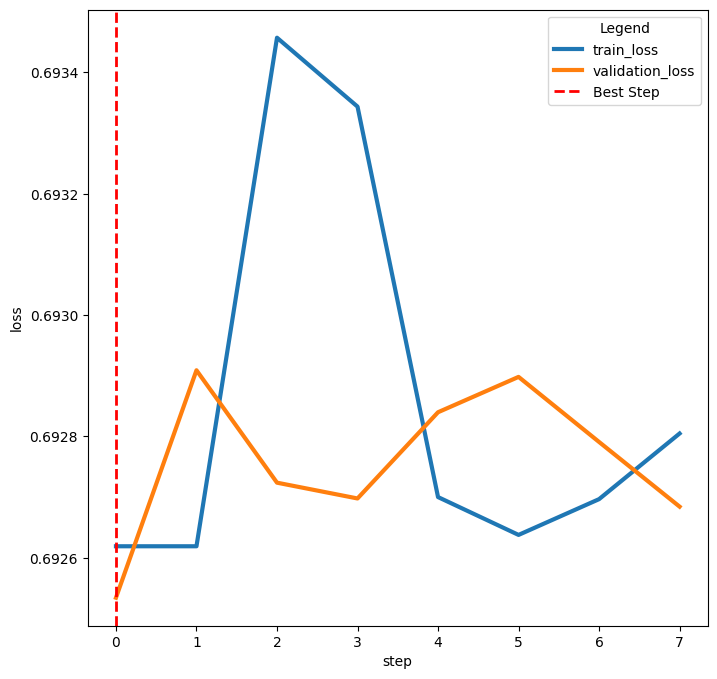

In [81]:



random_dataset_id = did
date_markup = '_'.join(str(datetime.datetime.now()).split()[0].split("-"))
# Finetune
save_path_to_fine_tuned_model = f"./fine_tuned_model_new_{date_markup}_regular_{random_dataset_id}.ckpt"

fine_tune_tabpfn(
    path_to_base_model="auto",
    save_path_to_fine_tuned_model=save_path_to_fine_tuned_model,
    # Finetuning HPs
  time_limit=200,
    finetuning_config={"learning_rate": 0.00001, "batch_size": 8,"min_patience": 300,"max_patience": 1000},
    validation_metric="log_loss",
    # Input Data
    X_train=X_train,
    y_train=y_train,
    categorical_features_index=None,
    device="cuda",  # use "cpu" if you don't have a GPU
    task_type="multiclass",
    # Optional
    show_training_curve=True,  # Shows a final report after finetuning.
    logger_level=-100,  # Shows all logs, higher values shows less
    use_wandb=False,  # Init wandb yourself, and set to True
)




In [82]:
save_path_to_fine_tuned_model = f"./fine_tuned_model_new_{date_markup}_regular_{random_dataset_id}.ckpt"
reg_model = TabPFNClassifier(
    model_path=save_path_to_fine_tuned_model,
)
# Then, use gated_model in your fine-tuning pipeline.
clf = reg_model.fit(X_train, y_train)
print("Log Loss (Default):", log_loss(y_test, clf.predict_proba(X_test)))

Loaded Regular Model


C:\conda_envs\ds310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Log Loss (Default): 0.6947513084195421


In [83]:
accuracy_score(y_test,np.argmax(clf.predict_proba(X_test),axis=1)),\
precision_score(y_test,np.argmax(clf.predict_proba(X_test),axis=1),\
average='weighted'),\
recall_score(y_test,np.argmax(clf.predict_proba(X_test),axis=1),average='weighted')

(0.4716535433070866, 0.3681613215201302, 0.4716535433070866)